/Users/jadmoawad/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/d4/4grl0kvj72b_xybjt3ptxv6w0000gn/T/ipykernel_16295/3359230470.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_data = df_long.groupby(['investment_label', group_var])['percentage'].mean().reset_index()
/var/folders/d4/4grl0kvj72b_xybjt3ptxv6w0000gn/T/ipykernel_16295/3359230470.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_data = df_long.groupby(['inve

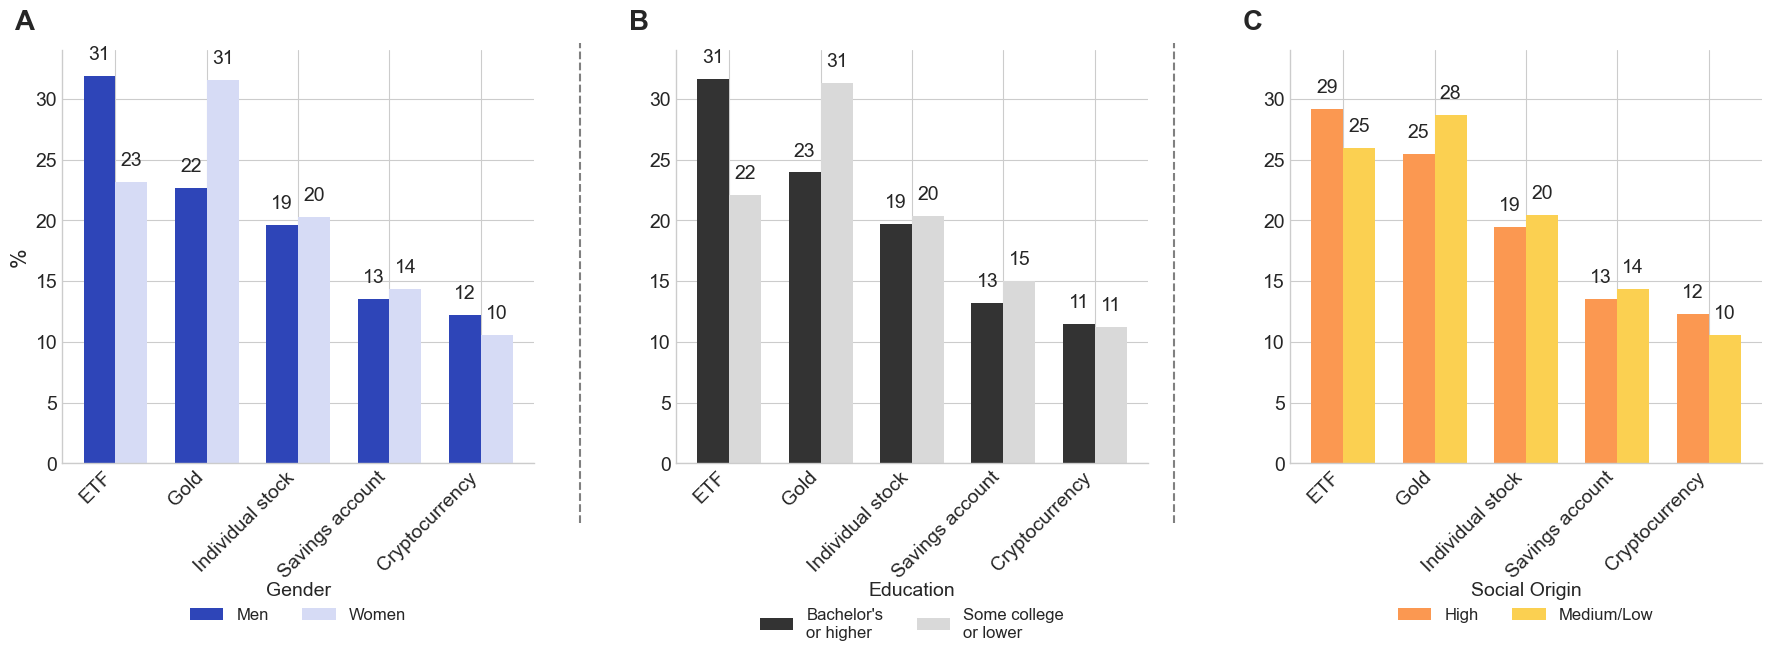

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import os
import pyreadr


# Load the processed data
df = pd.read_pickle('/Users/jadmoawad/Desktop/Github_financial_experiment/financial-literacy-experiment/data/processed_df.pkl')


# result = pyreadr.read_r('/Users/jadmoawad/Desktop/Article 7 Experiment_redistribution/Data/df.Rda')
# # Check what objects are in the file
# print("Objects in the R file:", list(result.keys()))
# # Get the first (and likely only) object
# df = result[list(result.keys())[0]]
# print(f"Loaded dataframe with shape: {df.shape}")

# Set default style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')  # Fallback for older versions
plt.rcParams.update({'font.size': 16})

def create_investment_plot(data, group_var, colors=['#475ED1', '#E3120B']):
    """
    Create investment preference bar plot by demographic group
    """
    # Ensure grouping variable is categorical
    data[group_var] = data[group_var].astype('category')
    
    # Select relevant columns and reshape to long format
    investment_cols = ['stock', 'etf', 'saving', 'gold', 'crypto']
    df_subset = data[investment_cols + [group_var]].copy()
    
    # Melt to long format (equivalent to pivot_longer)
    df_long = df_subset.melt(
        id_vars=[group_var],
        value_vars=investment_cols,
        var_name='investment_type',
        value_name='percentage'
    )
    
    # Create labels and ordering
    investment_labels = {
        'etf': 'ETF',
        'gold': 'Gold',
        'stock': 'Individual stock',
        'saving': 'Savings account',
        'crypto': 'Cryptocurrency'
    }
    df_long['investment_label'] = df_long['investment_type'].map(investment_labels)
    
    # Set order for investment types
    investment_order = ['ETF', 'Gold', 'Individual stock', 'Savings account', 'Cryptocurrency']
    df_long['investment_label'] = pd.Categorical(df_long['investment_label'], 
                                                  categories=investment_order, 
                                                  ordered=True)
    
    # Compute group means
    means_data = df_long.groupby(['investment_label', group_var])['percentage'].mean().reset_index()
    means_data.columns = ['investment_label', group_var, 'mean_value']
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Get unique groups
    groups = sorted(data[group_var].unique())
    
    # Set up bar positions
    x = np.arange(len(investment_order))
    width = 0.35
    
    # Plot bars for each group
    for i, group in enumerate(groups):
        group_data = means_data[means_data[group_var] == group]
        # Ensure data is in correct order
        group_data = group_data.set_index('investment_label').reindex(investment_order)
        
        offset = width * (i - 0.5)
        bars = ax.bar(x + offset, group_data['mean_value'], width, 
                      label=group, color=colors[i])
        
        # Add value labels on bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=14)
    
    # Customize plot
    ax.set_xlabel('')
    ax.set_ylabel('%', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(investment_order, rotation=45, ha='right', fontsize=14)
    ax.set_ylim(0, 34)
    ax.tick_params(axis='y', labelsize=14)
    
    # Format legend
    legend_title = group_var.replace('_', ' ').title()
    ax.legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, -0.2),
             ncol=2, frameon=False, fontsize=12, title_fontsize=14)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig, ax

# Tweak education factor labels with line breaks
df['education'] = pd.Categorical(df['education'])
education_mapping = {
    "Bachelor's or higher": "Bachelor's\nor higher",
    "Some college or lower": "Some college\nor lower"
}
df['education'] = df['education'].cat.rename_categories(education_mapping)

# Define color palettes for each subplot
colors_plot1 = ['#2E45B8', '#D6DBF5']
colors_plot2 = ['#333333', '#D9D9D9']
colors_plot3 = ['#FB9851', '#FBD051']

# Create the three demographic plots
fig1, ax1 = create_investment_plot(df, 'gender', colors=colors_plot1)
fig2, ax2 = create_investment_plot(df, 'education', colors=colors_plot2)
fig3, ax3 = create_investment_plot(df, 'social_origin', colors=colors_plot3)

# Create combined figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to transfer plot content from one axis to another
def transfer_plot(source_ax, target_ax):
    """Transfer all artists from source axis to target axis"""
    # Get the data from bars
    for artist in source_ax.get_children():
        if isinstance(artist, mpatches.Rectangle) and artist.get_height() > 0:
            # This is a bar
            target_ax.add_patch(Rectangle((artist.get_x(), artist.get_y()), 
                                        artist.get_width(), artist.get_height(),
                                        facecolor=artist.get_facecolor(),
                                        edgecolor=artist.get_edgecolor()))
        elif hasattr(artist, 'get_text') and artist.get_text():
            # This is text
            target_ax.text(artist.get_position()[0], artist.get_position()[1],
                         artist.get_text(), 
                         fontsize=artist.get_fontsize(),
                         ha=artist.get_ha(), va=artist.get_va())
    
    # Copy axis properties
    target_ax.set_xlim(source_ax.get_xlim())
    target_ax.set_ylim(source_ax.get_ylim())
    target_ax.set_xticks(source_ax.get_xticks())
    target_ax.set_xticklabels(source_ax.get_xticklabels(), rotation=45, ha='right')
    target_ax.set_xlabel(source_ax.get_xlabel())
    target_ax.set_ylabel(source_ax.get_ylabel())
    
    # Copy legend
    if source_ax.get_legend():
        handles, labels = source_ax.get_legend_handles_labels()
        target_ax.legend(handles, labels, 
                        title=source_ax.get_legend().get_title().get_text(),
                        loc='upper center', bbox_to_anchor=(0.5, -0.2),
                        ncol=2, frameon=False)

# Alternative approach: recreate plots directly in subplots
plt.close('all')
fig = plt.figure(figsize=(18, 6))

# Create subplots with shared y-axis
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharey=ax1)
ax3 = plt.subplot(1, 3, 3, sharey=ax1)

# Helper function to plot in a specific axis
def plot_in_axis(ax, data, group_var, colors):
    # Get unique groups
    groups = sorted(data[group_var].unique())
    
    # Prepare data
    investment_cols = ['stock', 'etf', 'saving', 'gold', 'crypto']
    investment_labels = {
        'etf': 'ETF',
        'gold': 'Gold',
        'stock': 'Individual stock',
        'saving': 'Savings account',
        'crypto': 'Cryptocurrency'
    }
    investment_order = ['ETF', 'Gold', 'Individual stock', 'Savings account', 'Cryptocurrency']
    
    # Calculate means
    means = {}
    for group in groups:
        group_data = data[data[group_var] == group]
        means[group] = []
        for inv_type in ['etf', 'gold', 'stock', 'saving', 'crypto']:
            means[group].append(group_data[inv_type].mean())
    
    # Plot bars
    x = np.arange(len(investment_order))
    width = 0.35
    
    for i, group in enumerate(groups):
        offset = width * (i - 0.5)
        bars = ax.bar(x + offset, means[group], width, 
                      label=group, color=colors[i])
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=14)
    
    # Customize
    ax.set_ylabel('%', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(investment_order, rotation=45, ha='right', fontsize=14)
    ax.set_ylim(0, 34)
    ax.tick_params(axis='y', labelsize=14)
    
    # Legend
    legend_title = group_var.replace('_', ' ').title()
    ax.legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, -0.25),
             ncol=2, frameon=False, fontsize=12, title_fontsize=14)
    
    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Plot in each axis
plot_in_axis(ax1, df, 'gender', colors_plot1)
plot_in_axis(ax2, df, 'education', colors_plot2)
plot_in_axis(ax3, df, 'social_origin', colors_plot3)

# Hide y-labels for middle and right plots
ax2.set_ylabel('')
ax3.set_ylabel('')

# Add panel labels
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold')
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold')
ax3.text(-0.1, 1.05, 'C', transform=ax3.transAxes, fontsize=20, fontweight='bold')

# Add vertical dashed lines between panels
# These are in figure coordinates
fig.add_artist(plt.Line2D([0.33, 0.33], [0.1, 0.9], color='gray', 
                         linestyle='--', transform=fig.transFigure))
fig.add_artist(plt.Line2D([0.66, 0.66], [0.1, 0.9], color='gray', 
                         linestyle='--', transform=fig.transFigure))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, wspace=0.3)

# Save the figure
output_dir = "/Users/jadmoawad/Desktop/R_experiment/Figures"
os.makedirs(output_dir, exist_ok=True)

# Save as PNG with high DPI
plt.savefig(os.path.join(output_dir, "figure_1.png"), 
           dpi=600, bbox_inches='tight')

# Save as PDF (vector format)
plt.savefig(os.path.join(output_dir, "figure_1.pdf"), 
           format='pdf', bbox_inches='tight')

# Display the plot
plt.show()

/var/folders/d4/4grl0kvj72b_xybjt3ptxv6w0000gn/T/ipykernel_16295/692532780.py:60: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  vals = df[outcomes].stack(dropna=True)


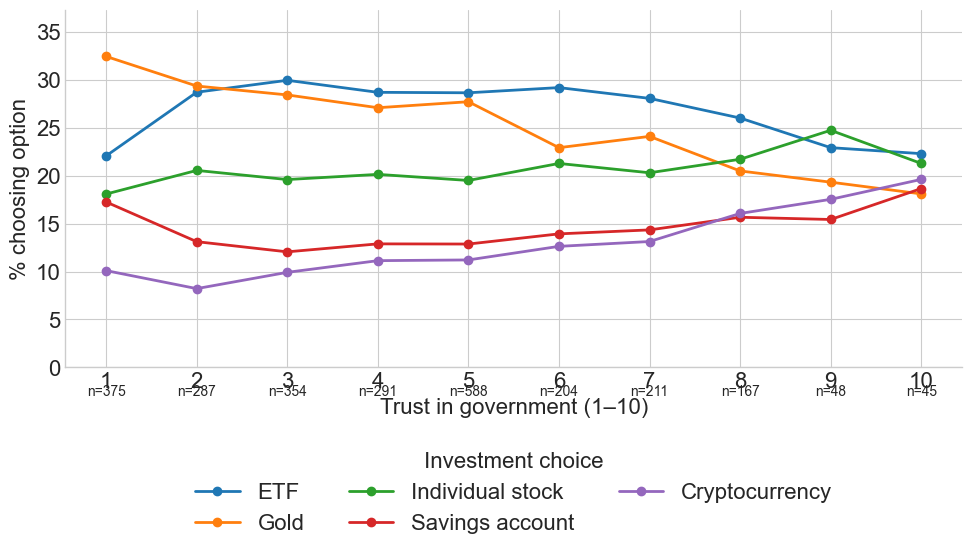

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ==============================
# 0) Load data
# ==============================
df = pd.read_pickle('/Users/jadmoawad/Desktop/Github_financial_experiment/financial-literacy-experiment/data/processed_df.pkl')

# ==============================
# 1) Locate the trust-in-gov column
#    (edit this list if needed)
# ==============================
trust_candidates = [
    'trust_gov', 'trust_government', 'trust_in_government', 'trust_govt',
    'gov_trust', 'government_trust', 'pol_trust_gov', 'trust_state'
]
trust_col = next((c for c in trust_candidates if c in df.columns), None)
if trust_col is None:
    raise KeyError(f"Couldn't find a government-trust column. "
                   f"Tried: {trust_candidates}\nAvailable: {list(df.columns)}")

# ==============================
# 2) Harmonize trust scale to 1–10 integers
#    (works if you have 0–10, 1–10, or decimals)
# ==============================
trust = pd.to_numeric(df[trust_col], errors='coerce')

# If scale looks 0–10, shift to 1–10
if trust.min() >= 0 and trust.max() <= 10 and (trust % 1 != 0).any():
    # decimals but within 0–10 → round
    pass  # we'll round below
if trust.min() >= 0 and trust.max() <= 10 and trust.dropna().astype(int).isin(range(0,11)).all():
    # contains 0–10 ints → map 0→1 to keep 10 levels if needed
    trust = trust.replace(0, 1)

# Round to nearest int, clip to [1,10]
trust_10 = np.round(trust).astype('Int64')
trust_10 = trust_10.clip(lower=1, upper=10)

df = df.copy()
df['trust_10'] = trust_10

# Drop rows without a valid trust score
df = df.dropna(subset=['trust_10'])

# ==============================
# 3) Prep outcomes
# ==============================
outcomes = ['etf', 'gold', 'stock', 'saving', 'crypto']
missing = [c for c in outcomes if c not in df.columns]
if missing:
    raise KeyError(f"Missing expected columns: {missing}")

for c in outcomes:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Convert proportions to % if needed
vals = df[outcomes].stack(dropna=True)
if len(vals) and np.nanquantile(vals, 0.95) <= 1.0:
    df[outcomes] = df[outcomes] * 100

# ==============================
# 4) Compute means by each trust point (1..10) + sample sizes
# ==============================
means = (df.groupby('trust_10', observed=True)[outcomes]
           .mean()
           .reindex(range(1, 11)))
ns = df.groupby('trust_10', observed=True).size().reindex(range(1, 11)).fillna(0).astype(int)

# ==============================
# 5) Plot: one panel, 5 lines (ETF, Gold, Stock, Saving, Crypto)
# ==============================
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each outcome as a line across trust=1..10
x = np.arange(1, 11)
labels_map = {
    'etf': 'ETF',
    'gold': 'Gold',
    'stock': 'Individual stock',
    'saving': 'Savings account',
    'crypto': 'Cryptocurrency'
}

for col in outcomes:
    y = means[col].values
    ax.plot(x, y, marker='o', linewidth=2, label=labels_map[col])

ax.set_xlabel('Trust in government (1–10)', fontsize=16)
ax.set_ylabel('% choosing option', fontsize=16)
ax.set_xticks(x)
ax.set_ylim(0, max(10, np.nanmax(means.values)*1.15))  # a bit of headroom

# Legend below the plot
leg = ax.legend(title='Investment choice', loc='upper center',
                bbox_to_anchor=(0.5, -0.18), ncol=3, frameon=False)

# Optional: show sample sizes under x-axis ticks
# (small annotation; comment out if you don’t want it)
for xi, n in zip(x, ns.values):
    ax.text(xi, ax.get_ylim()[0] - (ax.get_ylim()[1]*0.05), f"n={n}",
            ha='center', va='top', fontsize=10)

# Tidy spines/margins
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# ==============================
# 6) Save & show
# ==============================
outdir = "/Users/jadmoawad/Desktop/R_experiment/Figures"
os.makedirs(outdir, exist_ok=True)
plt.savefig(os.path.join(outdir, "investment_by_trust_1to10.png"), dpi=600, bbox_inches='tight')
plt.savefig(os.path.join(outdir, "investment_by_trust_1to10.pdf"), format='pdf', bbox_inches='tight')
plt.show()

# ==============================
# Quick tweaks
# - Fix y-axis: ax.set_ylim(0, 34)
# - If trust is already clean 1..10 ints, skip the remapping step.
# - To hide sample-size annotations, comment out the loop that writes n=...
# ==============================


Loaded dataframe with shape: (2570, 26)
Running model for ETF...
Running model for Individual stock...
Running model for Savings account...
Running model for Gold...
Running model for Cryptocurrency...


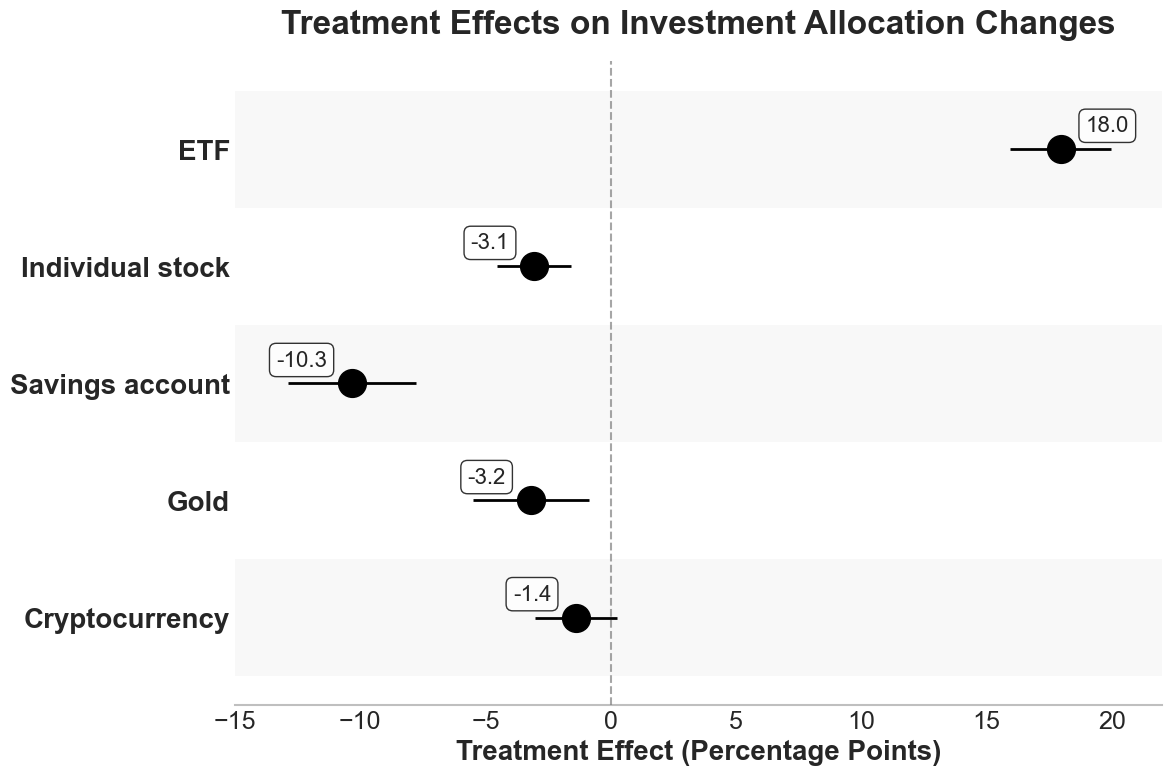



Summary of Treatment Effects:
Cryptocurrency      :  -1.38 ( -3.01,   0.26) 
Gold                :  -3.19 ( -5.52,  -0.87) **
Savings account     : -10.33 (-12.89,  -7.77) ***
Individual stock    :  -3.05 ( -4.54,  -1.57) ***
ETF                 :  17.95 ( 15.92,  19.98) ***


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResults
import statsmodels.formula.api as smf
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

# Load data
import pyreadr
df = pd.read_pickle('/Users/jadmoawad/Desktop/Github_financial_experiment/financial-literacy-experiment/data/processed_df.pkl')


# result = pyreadr.read_r('/Users/jadmoawad/Desktop/Article 7 Experiment_redistribution/Data/df.Rda')
# # Get the first object from the R file
# df = result[list(result.keys())[0]]
print(f"Loaded dataframe with shape: {df.shape}")

# Create change variables
df['etf_change'] = df['lot_etf'] - df['etf']
df['stock_change'] = df['lot_stock'] - df['stock']
df['saving_change'] = df['lot_saving'] - df['saving']
df['gold_change'] = df['lot_gold'] - df['gold']
df['crypto_change'] = df['lot_crypto'] - df['crypto']

# Define the control variables
control_vars = [
    'gender', 'education', 'social_origin', 'age', 'race', 
    'relationship_status', 'parents_us_born', 'labor_force', 
    'income', 'house', 'sub_financial_know', 'financial_literacy',
    'trust_government', 'political_placement', 'risk_tolerance'
]

# Function to run robust regression
def run_robust_regression(df, dependent_var, independent_vars):
    """
    Run OLS regression with heteroscedasticity-robust standard errors (HC1)
    """
    # Create formula
    formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
    
    # Fit the model
    model = smf.ols(formula, data=df).fit(cov_type='HC1')
    
    return model

# Run models for each investment type
models = {}
dependent_vars = ['etf_change', 'stock_change', 'saving_change', 'gold_change', 'crypto_change']
model_names = ['ETF', 'Individual stock', 'Savings account', 'Gold', 'Cryptocurrency']

for dep_var, name in zip(dependent_vars, model_names):
    print(f"Running model for {name}...")
    models[name] = run_robust_regression(df, dep_var, ['treatment'] + control_vars)

# Extract treatment coefficients
def get_treatment_coef(model, model_name):
    """Extract treatment coefficient with confidence intervals"""
    # Get coefficient
    coef = model.params['treatment']
    
    # Get standard error
    se = model.bse['treatment']
    
    # Get confidence intervals (95%)
    conf_low = model.conf_int().loc['treatment', 0]
    conf_high = model.conf_int().loc['treatment', 1]
    
    # Get p-value
    p_value = model.pvalues['treatment']
    
    return pd.DataFrame({
        'model': [model_name],
        'estimate': [coef],
        'std_error': [se],
        'conf_low': [conf_low],
        'conf_high': [conf_high],
        'p_value': [p_value]
    })

# Combine coefficients from all models
treatment_coefs = pd.concat([
    get_treatment_coef(models[name], name) 
    for name in model_names
], ignore_index=True)

# Convert model to categorical with specific ordering (reversed for top-to-bottom display)
treatment_coefs['model'] = pd.Categorical(
    treatment_coefs['model'], 
    categories=['ETF', 'Individual stock', 'Savings account', 'Gold', 'Cryptocurrency'][::-1],
    ordered=True
)

# Sort by the categorical order
treatment_coefs = treatment_coefs.sort_values('model')

# Create the coefficient plot with improved aesthetics
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Add title
plt.title('Treatment Effects on Investment Allocation Changes', 
          fontsize=24, fontweight='bold', pad=20)

# Vertical line at 0
ax.axvline(x=0, linestyle='--', color='gray', linewidth=1.5, alpha=0.7)

# Plot points and error bars
y_positions = range(len(treatment_coefs))
for i, (idx, row) in enumerate(treatment_coefs.iterrows()):
    y_pos = i
    
    # Add alternating background shading for better readability
    if y_pos % 2 == 0:
        ax.axhspan(y_pos - 0.5, y_pos + 0.5, facecolor='gray', alpha=0.05)
    
    # Point estimate
    ax.scatter(row['estimate'], y_pos, s=400, color='black', zorder=3)
    
    # Error bars
    ax.errorbar(row['estimate'], y_pos, 
                xerr=[[row['estimate'] - row['conf_low']], 
                      [row['conf_high'] - row['estimate']]], 
                fmt='none', color='black', linewidth=2, capsize=0)
    
    # Coefficient value with better positioning
    # Position based on estimate sign for better readability
    # Moved up by 0.2 to avoid touching the dot
    if row['estimate'] > 0:
        ax.text(row['estimate'] + 1.0, y_pos + 0.2, f"{row['estimate']:.1f}", 
                ha='left', va='center', fontsize=16, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    else:
        ax.text(row['estimate'] - 1.0, y_pos + 0.2, f"{row['estimate']:.1f}", 
                ha='right', va='center', fontsize=16, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Customize plot
ax.set_yticks(range(len(treatment_coefs)))
ax.set_yticklabels([row['model'] for idx, row in treatment_coefs.iterrows()], 
                   fontsize=20, weight='bold')
ax.set_xlabel('Treatment Effect (Percentage Points)', fontsize=20, fontweight='bold')
ax.set_ylabel('')
ax.set_xlim(-15, 22)

# Customize x-axis
ax.tick_params(axis='x', labelsize=18, which='major', length=0)
ax.tick_params(axis='y', length=0)

# Set specific x-axis ticks
ax.set_xticks([-15, -10, -5, 0, 5, 10, 15, 20])

# Remove all gridlines except the dashed line at zero
ax.grid(False)
ax.set_axisbelow(True)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)

# Add subtle box around the plot area
ax.spines['bottom'].set_color('gray')
ax.spines['bottom'].set_alpha(0.5)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)

# Save the figure
output_dir = "/Users/jadmoawad/Desktop/R_experiment/Figures"
os.makedirs(output_dir, exist_ok=True)

# Save as PDF
plt.savefig(os.path.join(output_dir, "treatment_effects_improved.pdf"), 
           dpi=2300, bbox_inches='tight', format='pdf')

# Save as PNG
plt.savefig(os.path.join(output_dir, "treatment_effects_improved.png"), 
           dpi=600, bbox_inches='tight')

plt.show()

# Print summary statistics
print("\n\nSummary of Treatment Effects:")
print("=" * 60)
for idx, row in treatment_coefs.iterrows():
    sig = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else ''
    print(f"{row['model']:20s}: {row['estimate']:6.2f} ({row['conf_low']:6.2f}, {row['conf_high']:6.2f}) {sig}")
print("=" * 60)

Loaded dataframe with shape: (2568, 27)
Creating Panel A (Gender)...
Creating Panel B (Education)...
Creating Panel C (Social Origin)...


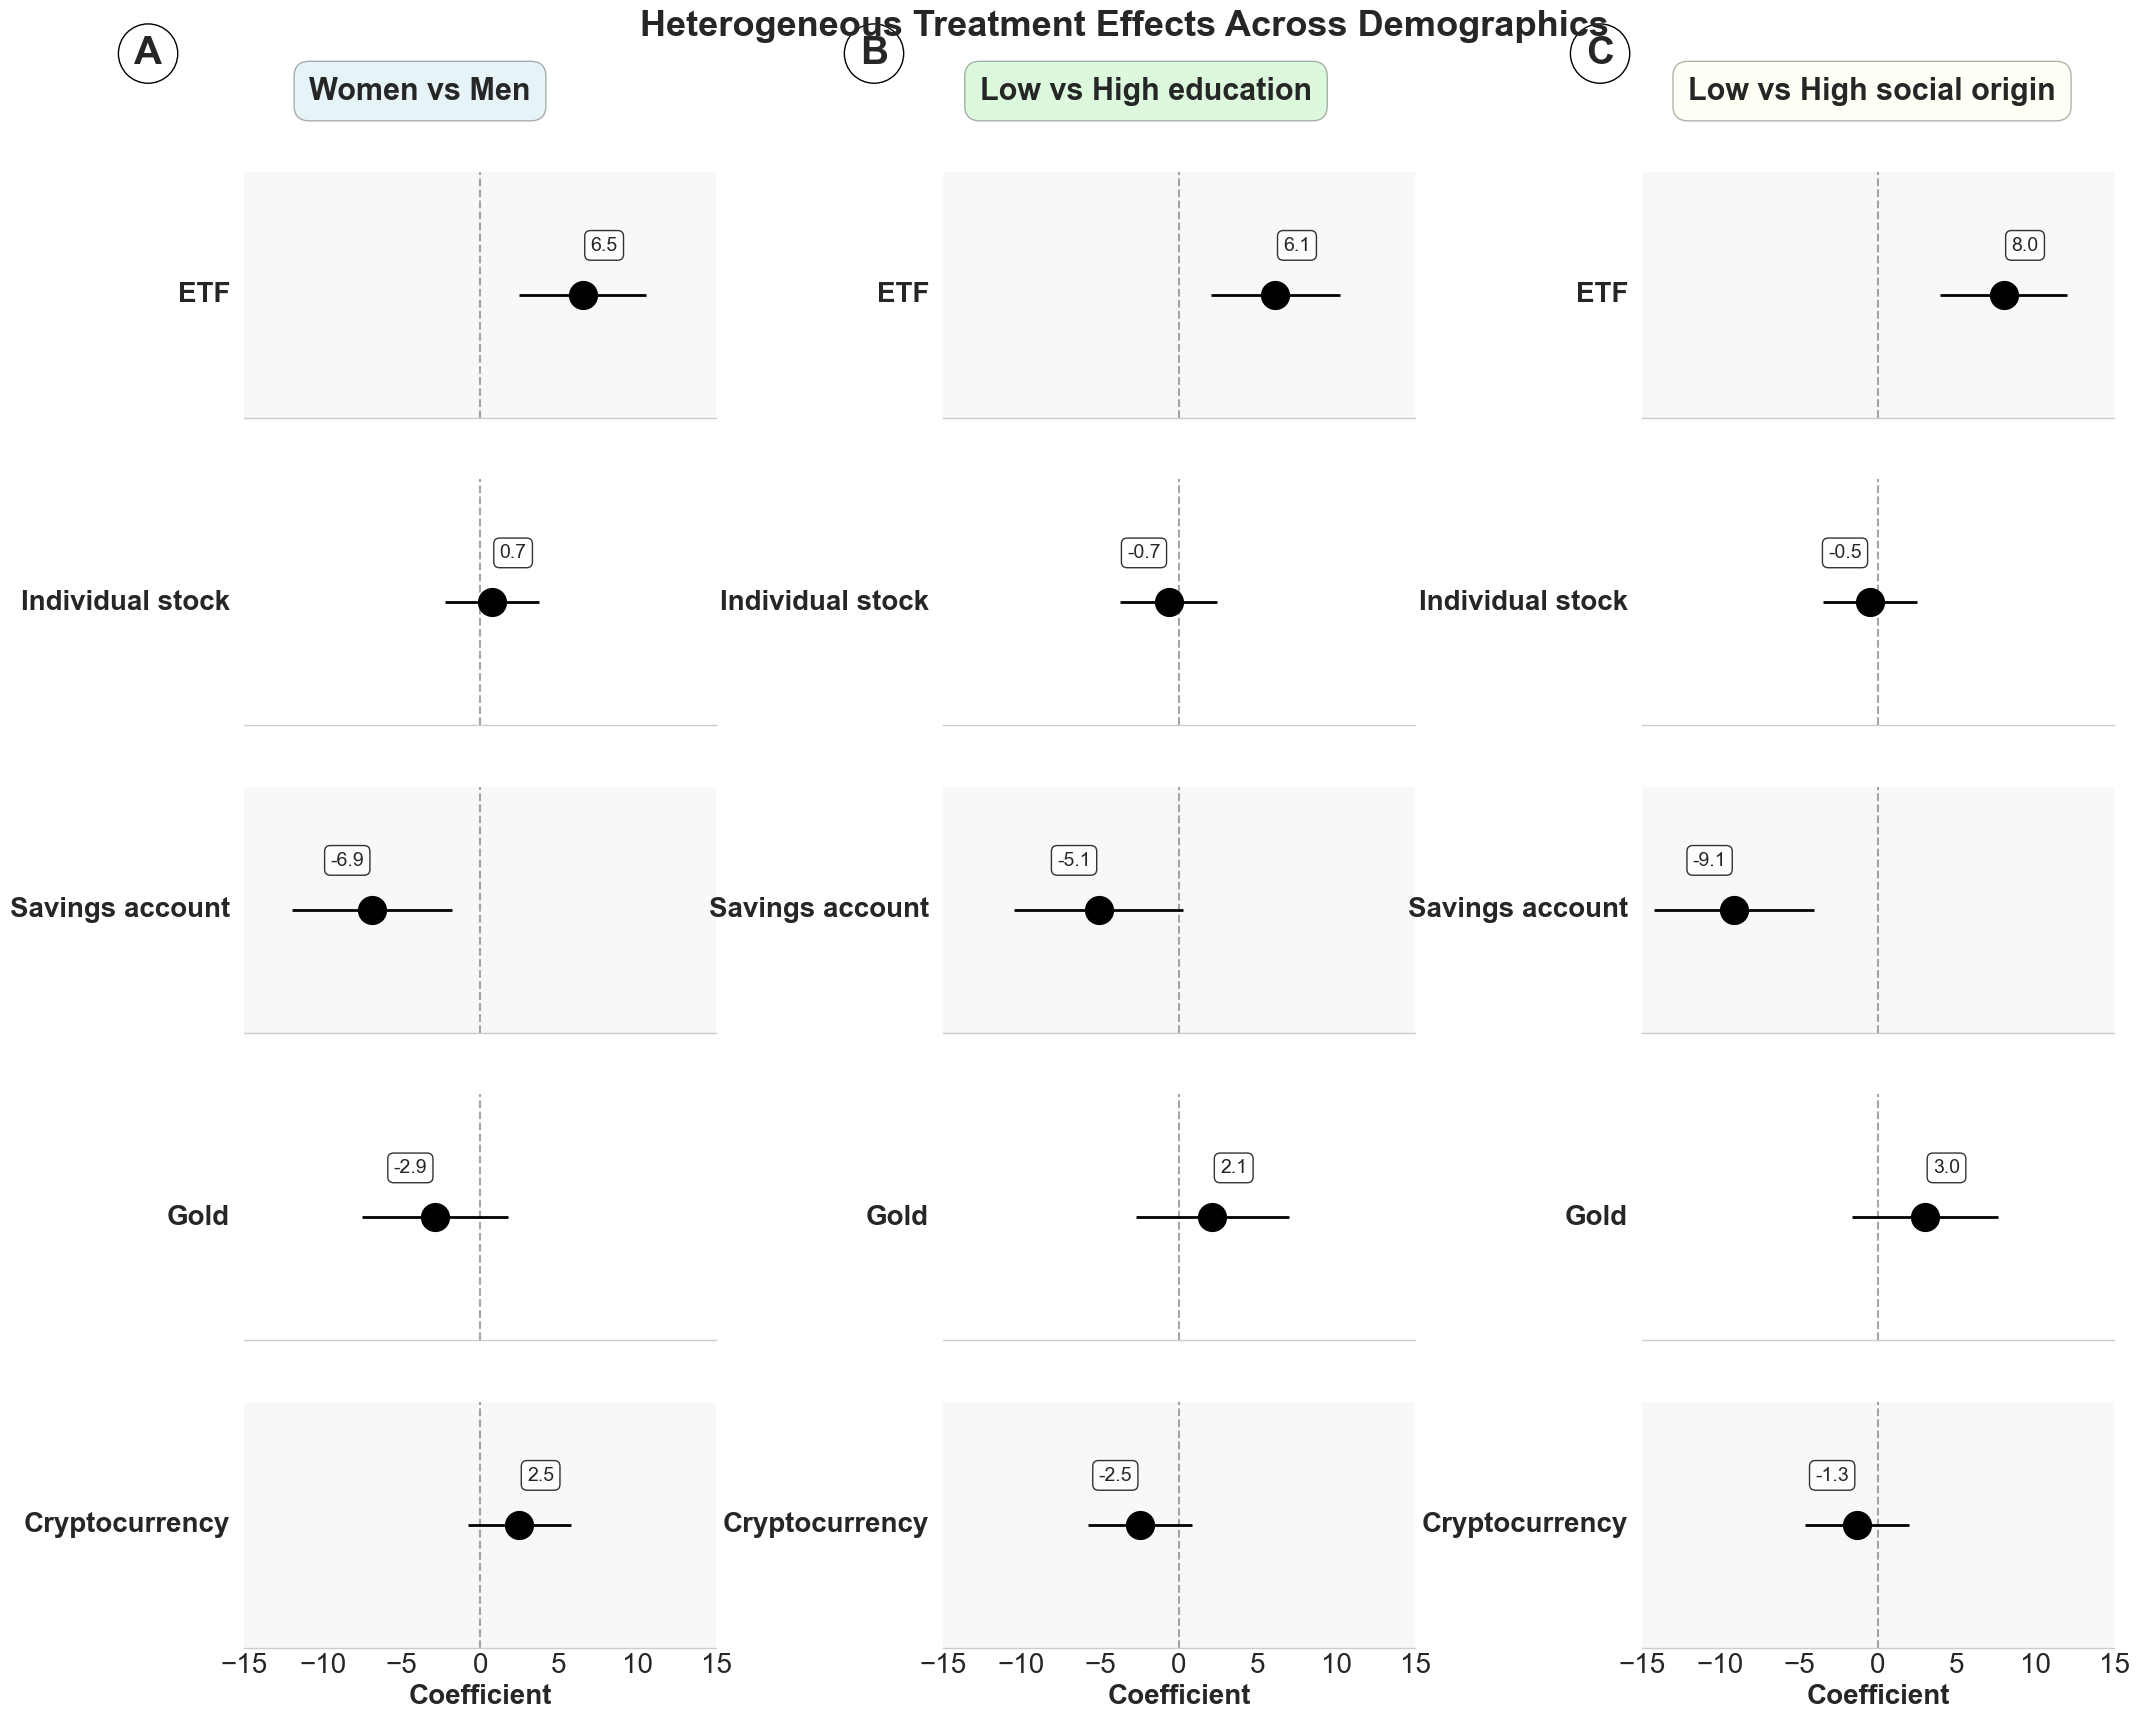



Summary of Heterogeneous Treatment Effects:

GENDER interactions:
  etf_change:   6.52 **
  stock_change:   0.74 
  saving_change:  -6.87 **
  gold_change:  -2.87 
  crypto_change:   2.49 

EDUCATION interactions:
  etf_change:   6.13 **
  stock_change:  -0.66 
  saving_change:  -5.10 
  gold_change:   2.11 
  crypto_change:  -2.48 

SOCIAL_ORIGIN interactions:
  etf_change:   7.99 ***
  stock_change:  -0.53 
  saving_change:  -9.12 ***
  gold_change:   3.00 
  crypto_change:  -1.34 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import warnings
warnings.filterwarnings('ignore')

# # Load data
# import pyreadr
# df = pd.read_pickle('/Users/jadmoawad/Desktop/Github_financial_experiment/financial-literacy-experiment/data/processed_df.pkl')

result = pyreadr.read_r('/Users/jadmoawad/Desktop/Article 7 Experiment_redistribution/Data/df.Rda')
# Get the first object from the R file
df = result[list(result.keys())[0]]

print(f"Loaded dataframe with shape: {df.shape}")

# Create change variables
df['etf_change'] = df['lot_etf'] - df['etf']
df['stock_change'] = df['lot_stock'] - df['stock']
df['saving_change'] = df['lot_saving'] - df['saving']
df['gold_change'] = df['lot_gold'] - df['gold']
df['crypto_change'] = df['lot_crypto'] - df['crypto']

# Define control variables (excluding the interaction demographic)
base_controls = [
    'age', 'race', 'relationship_status', 'parents_us_born', 
    'labor_force', 'income', 'house', 'sub_financial_know', 
    'financial_literacy', 'trust_government', 'political_placement', 
    'risk_tolerance'
]

def create_demographic_panel(df, demographic_var, ax_list):
    """
    Create a panel of plots for a specific demographic variable
    """
    outcomes = ['etf_change', 'stock_change', 'saving_change', 'gold_change', 'crypto_change']
    outcome_labels = ['ETF', 'Individual stock', 'Savings account', 'Gold', 'Cryptocurrency']
    
    # Define the interaction term based on demographic
    if demographic_var == 'gender':
        # Assuming 'Women' is the non-reference category
        interaction_term = 'treatment:C(gender)[T.Women]'
        controls = base_controls
    elif demographic_var == 'education':
        # Assuming 'Some college or lower' is the non-reference category
        interaction_term = 'treatment:C(education)[T.Some college or lower]'
        controls = base_controls
    elif demographic_var == 'social_origin':
        # Assuming 'Medium/Low' is the non-reference category
        interaction_term = 'treatment:C(social_origin)[T.Medium/Low]'
        controls = base_controls
    
    # Process each outcome
    for i, (outcome, label, ax) in enumerate(zip(outcomes, outcome_labels, ax_list)):
        # Build formula with interaction
        formula = f"{outcome} ~ treatment * C({demographic_var}) + {' + '.join(controls)}"
        
        # Fit robust regression
        try:
            model = smf.ols(formula, data=df).fit(cov_type='HC1')
            
            # Extract interaction coefficient
            if interaction_term in model.params.index:
                estimate = model.params[interaction_term]
                conf_low = model.conf_int().loc[interaction_term, 0]
                conf_high = model.conf_int().loc[interaction_term, 1]
                p_value = model.pvalues[interaction_term]
            else:
                # Try alternative naming conventions
                possible_terms = [k for k in model.params.index if 'treatment:' in k and demographic_var in k]
                if possible_terms:
                    term = possible_terms[0]
                    estimate = model.params[term]
                    conf_low = model.conf_int().loc[term, 0]
                    conf_high = model.conf_int().loc[term, 1]
                    p_value = model.pvalues[term]
                else:
                    print(f"Warning: Could not find interaction term for {demographic_var} in {outcome}")
                    continue
            
            # Plot
            ax.axvline(x=0, linestyle='--', color='gray', linewidth=1.5, alpha=0.7)
            ax.scatter(estimate, 0.5, s=400, color='black', zorder=3)
            ax.errorbar(estimate, 0.5, 
                       xerr=[[estimate - conf_low], [conf_high - estimate]], 
                       fmt='none', color='black', linewidth=2, capsize=0)
            
            # Coefficient value - position based on estimate sign for better readability
            # Moved up to 0.7 to avoid touching the dot
            if estimate > 0:
                ax.text(estimate + 0.5, 0.7, f"{estimate:.1f}", ha='left', va='center', 
                       fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
            else:
                ax.text(estimate - 0.5, 0.7, f"{estimate:.1f}", ha='right', va='center', 
                       fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
            
        except Exception as e:
            print(f"Error in model for {outcome} with {demographic_var}: {str(e)}")
        
        # Customize axes
        ax.set_xlim(-15, 15)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        
        # Set x-axis ticks
        ax.set_xticks([-15, -10, -5, 0, 5, 10, 15])
        
        # Remove tick marks (the small lines at each tick position)
        ax.tick_params(axis='x', which='both', length=0)
        
        # Set y-axis labels with better positioning
        ax.set_ylabel(label, fontsize=20, fontweight='bold', rotation=0, 
                     ha='right', va='center', labelpad=10)
        
        # Only show x-axis labels for bottom plot
        if i == len(outcomes) - 1:
            ax.tick_params(axis='x', labelsize=20, length=0)
            ax.set_xlabel('Coefficient', fontsize=20, fontweight='bold')
        else:
            ax.set_xticklabels([])
        
        # No grid - we only want the dashed line at zero
        ax.grid(False)
        ax.set_axisbelow(True)
        
        # Add light horizontal background shading for better readability
        if i % 2 == 0:
            ax.axhspan(0, 1, facecolor='gray', alpha=0.05)
        
        # Remove spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

# Create figure with custom layout - increased size for better spacing
fig = plt.figure(figsize=(22, 18))

# Create main grid for three columns with more space between panels
gs_main = gridspec.GridSpec(1, 5, width_ratios=[1, 0.15, 1, 0.15, 1], 
                           wspace=0.25, hspace=0.3)

# Create sub-grids for each panel (5 rows each) with more vertical space
gs_panel_a = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs_main[0, 0], 
                                              hspace=0.25)
gs_panel_b = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs_main[0, 2], 
                                              hspace=0.25)
gs_panel_c = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs_main[0, 4], 
                                              hspace=0.25)

# Create axes for each panel
axes_a = [fig.add_subplot(gs_panel_a[i, 0]) for i in range(5)]
axes_b = [fig.add_subplot(gs_panel_b[i, 0]) for i in range(5)]
axes_c = [fig.add_subplot(gs_panel_c[i, 0]) for i in range(5)]

# Create panels
print("Creating Panel A (Gender)...")
create_demographic_panel(df, 'gender', axes_a)
print("Creating Panel B (Education)...")
create_demographic_panel(df, 'education', axes_b)
print("Creating Panel C (Social Origin)...")
create_demographic_panel(df, 'social_origin', axes_c)

# Add panel labels (A, B, C) with better positioning
fig.text(0.05, 0.96, 'A', fontsize=28, fontweight='bold', transform=fig.transFigure,
         bbox=dict(boxstyle="circle,pad=0.3", facecolor='white', edgecolor='black'))
fig.text(0.38, 0.96, 'B', fontsize=28, fontweight='bold', transform=fig.transFigure,
         bbox=dict(boxstyle="circle,pad=0.3", facecolor='white', edgecolor='black'))
fig.text(0.71, 0.96, 'C', fontsize=28, fontweight='bold', transform=fig.transFigure,
         bbox=dict(boxstyle="circle,pad=0.3", facecolor='white', edgecolor='black'))

# Add panel titles with better spacing
fig.text(0.18, 0.94, 'Women vs Men', fontsize=22, fontweight='bold', 
         ha='center', transform=fig.transFigure,
         bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.3))
fig.text(0.51, 0.94, 'Low vs High education', fontsize=22, fontweight='bold', 
         ha='center', transform=fig.transFigure,
         bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgreen', alpha=0.3))
fig.text(0.84, 0.94, 'Low vs High social origin', fontsize=22, fontweight='bold', 
         ha='center', transform=fig.transFigure,
         bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow', alpha=0.3))

# Add a main title
fig.suptitle('Heterogeneous Treatment Effects Across Demographics', 
             fontsize=26, fontweight='bold', y=0.99)

# Adjust layout with more space for margins
plt.subplots_adjust(left=0.10, right=0.95, top=0.90, bottom=0.08)

# Save the figure
output_dir = "/Users/jadmoawad/Desktop/R_experiment/Figures"
os.makedirs(output_dir, exist_ok=True)

# Save as PDF
plt.savefig(os.path.join(output_dir, "fig_4_improved.pdf"), 
           dpi=2300, bbox_inches='tight', format='pdf')

# Save as PNG
plt.savefig(os.path.join(output_dir, "fig_4_improved.png"), 
           dpi=600, bbox_inches='tight')

plt.show()

# Print summary of interaction effects
print("\n\nSummary of Heterogeneous Treatment Effects:")
print("=" * 60)

demographics = ['gender', 'education', 'social_origin']
outcomes = ['etf_change', 'stock_change', 'saving_change', 'gold_change', 'crypto_change']

for demo in demographics:
    print(f"\n{demo.upper()} interactions:")
    for outcome in outcomes:
        formula = f"{outcome} ~ treatment * C({demo}) + {' + '.join(base_controls)}"
        try:
            model = smf.ols(formula, data=df).fit(cov_type='HC1')
            interaction_terms = [k for k in model.params.index if 'treatment:' in k and demo in k]
            if interaction_terms:
                term = interaction_terms[0]
                coef = model.params[term]
                pval = model.pvalues[term]
                sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
                print(f"  {outcome}: {coef:6.2f} {sig}")
        except:
            print(f"  {outcome}: Error in estimation")